# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, float64, complex128
from numba.cuda import jit as cuda_jit
import math

import few

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import KerrEccEqFlux
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
from few.summation.interpolatedmodesum import InterpolatedModeSum 


from few.utils.ylm import GetYlms

from few import get_file_manager

from few.waveform import FastKerrEccentricEquatorialFlux

from few.utils.geodesic import get_fundamental_frequencies

from few.utils.constants import YRSID_SI
from few.waveform import GenerateEMRIWaveform, FastSchwarzschildEccentricFlux, FastKerrEccentricEquatorialFlux


import os
import sys

# Change to the desired directory
os.chdir('/nfs/home/svu/e1498138/localgit/FEWNEW/work/')

# Add it to Python path
sys.path.insert(0, '/nfs/home/svu/e1498138/localgit/FEWNEW/work/')

import GWfuncs
import loglike
import modeselector
import dynesty
# import gc
# import pickle
import cupy as cp

# tune few configuration
cfg_set = few.get_config_setter(reset=True)
cfg_set.set_log_level("info")



In [2]:
import stableemrifisher
stableemrifisher.__file__

'/nfs/home/svu/e1498138/localgit/Fisher/StableEMRIFisher/stableemrifisher/__init__.py'

In [3]:
from tqdm import tqdm
from stableemrifisher.fisher.fisher import StableEMRIFisher
from stableemrifisher.utils import inner_product

startup


# Setting Up

In [4]:
# GPU configuration
use_gpu = True
dt = 10     # Time step
T = 0.25   # Total time

In [5]:
# keyword arguments for inspiral generator 
inspiral_kwargs={
        "func": 'KerrEccEqFlux',
        "DENSE_STEPPING": 0, #change to 1/True for uniform sampling
        "include_minus_m": False, 
        "err": 1e-15  # Error tolerance 
}

# keyword arguments for inspiral generator 
amplitude_kwargs = {
    "force_backend": "cuda12x" # Force GPU
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "force_backend": "cuda12x",  # Force GPU
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "force_backend": "cuda12x",  # Force GPU
    "pad_output": True
}

In [6]:
gwf = GWfuncs.GravWaveAnalysis(T, dt)

In [7]:
waveform_class = FastKerrEccentricEquatorialFlux
waveform_class_kwargs = dict(inspiral_kwargs=inspiral_kwargs,
                             amplitude_kwargs=amplitude_kwargs,
                             Ylm_kwargs=Ylm_kwargs,
                             sum_kwargs=sum_kwargs,
                             use_gpu=use_gpu)

 
#waveform generator setup
waveform_generator = GenerateEMRIWaveform
waveform_generator_kwargs = dict(frame='detector')

In [8]:
gew_waveform_gen = GenerateEMRIWaveform(
    waveform_class, 
    frame='detector',
    inspiral_kwargs=inspiral_kwargs, 
    amplitude_kwargs=amplitude_kwargs, 
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu
)

In [9]:
sef = StableEMRIFisher(waveform_class=waveform_class, 
                       waveform_class_kwargs=waveform_class_kwargs,
                       waveform_generator=waveform_generator,
                       waveform_generator_kwargs=waveform_generator_kwargs,
                      stats_for_nerds = True, use_gpu = use_gpu,
                      deriv_type='stable')


In [10]:
# Params list
# TODO: check these parameters, fisher matrices still not positive definite

# Source parameters
m1 = 1e6
m2 = 3e1
a = 0.7
p0 = 7.5
e0 = 0.4 
xI0 = 1.0
dist = 3 # Gpc
# Polar and azimuthal angles .. detector frame
# S = Solar system barycenter
# K = spin angular momentum of the MBH
qS = 0.5 # TODO: should this also be fixed?
phiS = 1 #TODO just keep this fixed i think i keep getting negative
qK = 1
phiK = 1.5 #TODO should this also be fixed?
# Phases
Phi_phi0 = 0.4
Phi_theta0 = 0.0 # equatorial
Phi_r0 = 0.5




In [11]:
np.cos(phiS-phiK)

0.8775825618903728

In [12]:
np.cos(qS)*np.sin(qK)*np.cos(phiS - phiK)-np.sin(qS)*np.cos(qK)

0.389025125110443

In [13]:
np.cos(qK)*np.sin(qS)*np.cos(phiS - phiK)-np.sin(qK)*np.cos(qS)

-0.5111359058977083

In [14]:
traj_mod = sef.waveform_generator.waveform_generator.inspiral_generator

In [15]:
# Check if plunging or not
from few.utils.utility import get_p_at_t 

get_p_at_t(traj_module=traj_mod,t_out=0.25,traj_args=[m1, m2, a, e0, xI0])

7.234873408728496

# Sanity check of produced waveforms with SEF

In [16]:
# Generate waveform with waveform generator backend in SEF
sef_waveform_gen = sef.waveform_generator
sef_waveform = sef_waveform_gen(m1, m2, a, p0, e0, xI0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0,  T=T, dt=dt)

In [17]:
sef_waveform

array([ 1.95933653e-22+1.40786933e-22j,  1.55210660e-22+1.83191352e-22j,
        1.07150926e-22+2.12935249e-22j, ...,
       -4.83255384e-23+2.39727340e-22j, -1.08697121e-22+2.06112197e-22j,
       -1.53979483e-22+1.61038587e-22j])

In [18]:
# Generate w GenerateEMRIWaveform
gew_waveform = gew_waveform_gen(m1, m2, a, p0, e0, xI0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0, T=T, dt=dt)
gew_waveform

array([ 1.95933653e-22+1.40786933e-22j,  1.55210660e-22+1.83191352e-22j,
        1.07150926e-22+2.12935249e-22j, ...,
       -4.83255384e-23+2.39727340e-22j, -1.08697121e-22+2.06112197e-22j,
       -1.53979483e-22+1.61038587e-22j])

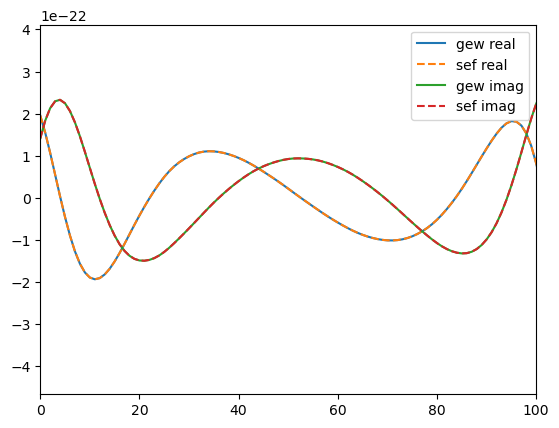

In [19]:
plt.plot(gew_waveform.get().real, label='gew real')
plt.plot(sef_waveform.get().real, label='sef real', linestyle='dashed')
plt.plot(gew_waveform.get().imag, label='gew imag')
plt.plot(sef_waveform.get().imag, label='sef imag', linestyle='dashed')
plt.legend(loc='upper right')
plt.xlim(0, 100)
plt.show()

In [20]:
T, dt

(0.25, 10)

In [21]:
gwf = GWfuncs.GravWaveAnalysis(T, dt)

In [22]:
hf = gwf.freq_wave(sef_waveform)

In [23]:
np.sqrt(gwf.inner(hf,hf))

array(21.27734364)

# Checking response functions

In [24]:
N = len(sef_waveform)

In [25]:
from lisatools.sensitivity import get_sensitivity, LISASens, CornishLISASens
fft_freqs = np.fft.rfftfreq(N, dt)
Sn = get_sensitivity(fft_freqs[1:], sens_fn=CornishLISASens, return_type="PSD")

In [26]:
from stableemrifisher.utils import SNRcalc
from stableemrifisher.noise import noise_PSD_AE
from stableemrifisher.utils import generate_PSD

In [27]:
waveform = np.asarray([sef_waveform.get().real, -sef_waveform.get().imag])
waveform

array([[ 1.95933653e-22,  1.55210660e-22,  1.07150926e-22, ...,
        -4.83255384e-23, -1.08697121e-22, -1.53979483e-22],
       [-1.40786933e-22, -1.83191352e-22, -2.12935249e-22, ...,
        -2.39727340e-22, -2.06112197e-22, -1.61038587e-22]])

In [28]:
noise_kwargs = {"TDI": "TDI1"}
channels = ["A", "E"]

In [29]:
PSD_alt = generate_PSD(waveform=waveform, dt=dt, noise_PSD=noise_PSD_AE,
                 channels=channels, noise_kwargs=noise_kwargs, use_gpu=False)

In [30]:
SNRcalc(waveform, PSD_alt, dt=dt)

548.4371746512111

In [31]:
SNRcalc(waveform, Sn, dt=dt)

21.27734364229831

# Calculating Fisher matrix

In [32]:
pars_list = [m1, m2, a, p0, e0, xI0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
# NOTE: leaving off xI0 and Phi_theta0 for now as fixed
param_names = ['m1','m2','a','p0','e0','dist','qS','phiS','Phi_phi0','Phi_r0']


In [33]:
der_order = 4
Ndelta = 8
stability_plot = True
# using default delta range first by SEF

T:  0.25 dt:  10
Body is not plunging, Fisher should be stable.
wave ndim: 2
Computing SNR for parameters: (1000000.0, 30.0, 0.7, 7.5, 0.4, 1.0, 3, 0.5, 1, 1, 1.5, 0.4, 0.0, 0.5)
Waveform Generated. SNR: 548.4371746512114
calculating stable deltas...
Gamma_ii for m1: 5061.3589133364285
Gamma_ii for m1: 5061.358913238283
Gamma_ii for m1: 5061.3589132542
Gamma_ii for m1: 5061.35891368176
Gamma_ii for m1: 5061.35891440112
Gamma_ii for m1: 5061.358891737038
Gamma_ii for m1: 5061.358688176009
Gamma_ii for m1: 5061.35955998968
[1.9391114904144648e-11, 3.1448207978386857e-12, 8.44753025932611e-11, 1.42127894713609e-10, 4.477865088216561e-09, 4.0218652979377325e-08, 1.7224891063264665e-07]
1


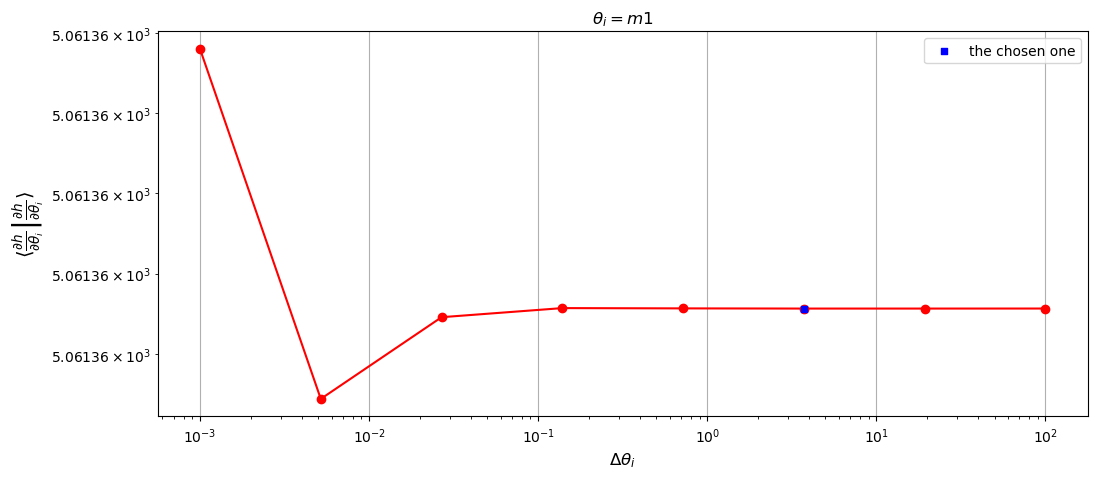

Gamma_ii for m2: 184409629407.22455
Gamma_ii for m2: 184409629406.4246
Gamma_ii for m2: 184409629362.8162
Gamma_ii for m2: 184409628924.1249
Gamma_ii for m2: 184409630301.09518
Gamma_ii for m2: 184409624954.3177
Gamma_ii for m2: 184409562568.09192
Gamma_ii for m2: 184409517732.13217
[4.337936570695996e-12, 2.3647571218584675e-10, 2.378895759072247e-09, 7.466910885460024e-09, 2.899402619392781e-08, 3.3830255275404874e-07, 2.4313256874540417e-07]
0


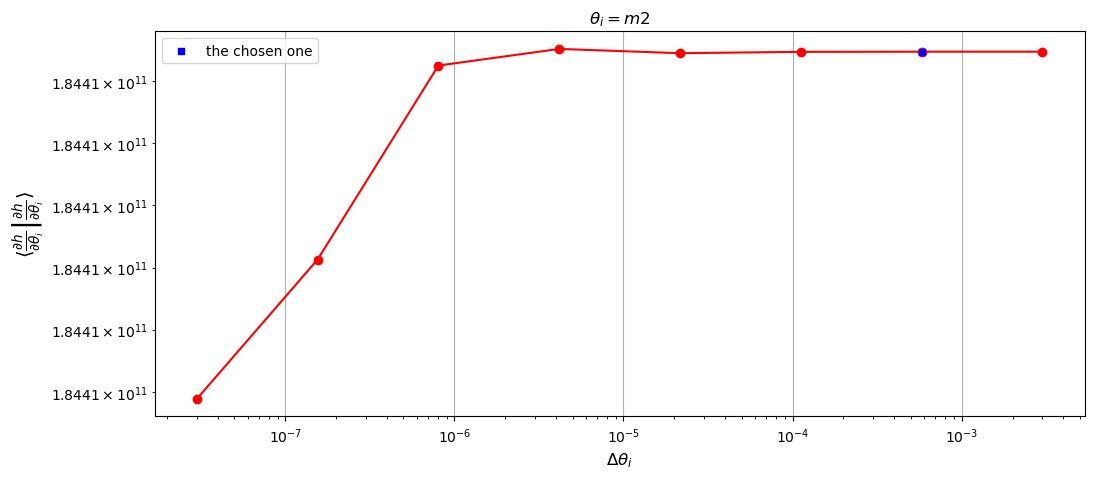

Gamma_ii for a: 383185585229036.9
Gamma_ii for a: 383185675282966.25
Gamma_ii for a: 383185454558909.7
Gamma_ii for a: 383185017134664.2
Gamma_ii for a: 383168313055214.8
Gamma_ii for a: 383202097660589.6
Gamma_ii for a: 384005189548226.56
Gamma_ii for a: 385567346321929.0
[2.3501382014998087e-07, 5.760240999141751e-07, 1.14154840596566e-06, 4.359462638281347e-05, 8.816393642170575e-05, 0.0020913568605199244, 0.004051579545323106]
0


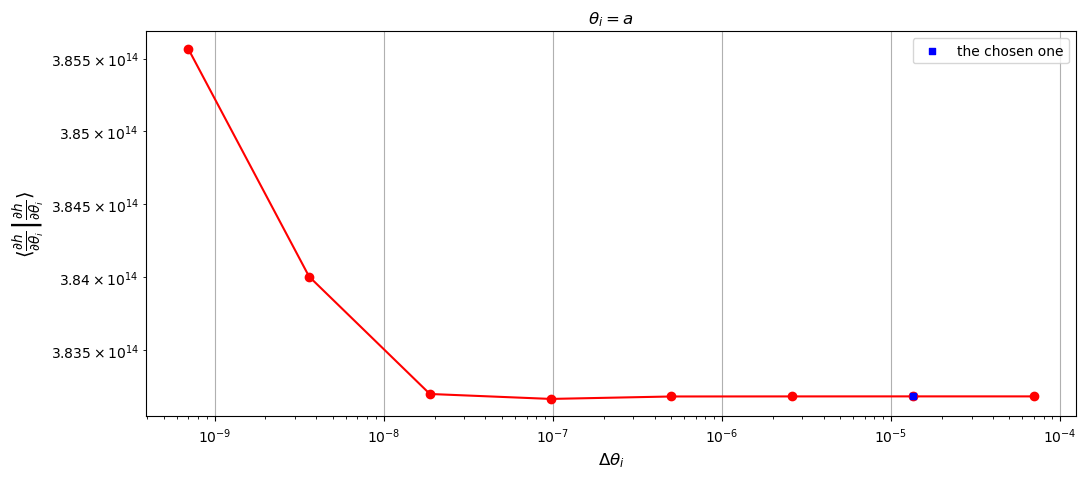

Gamma_ii for p0: 272484532052387.1
Gamma_ii for p0: 272484530316586.06
Gamma_ii for p0: 272484539061232.25
Gamma_ii for p0: 272484653541118.06
Gamma_ii for p0: 272484565115576.6
Gamma_ii for p0: 272486305180452.97
Gamma_ii for p0: 272480839458341.34
Gamma_ii for p0: 272407024653950.53
[6.370273678411248e-09, 3.2092265556156634e-08, 4.201333334731269e-07, 3.245157810360509e-07, 6.385880109544034e-06, 2.0059106256756214e-05, 0.0002709724702752522]
0


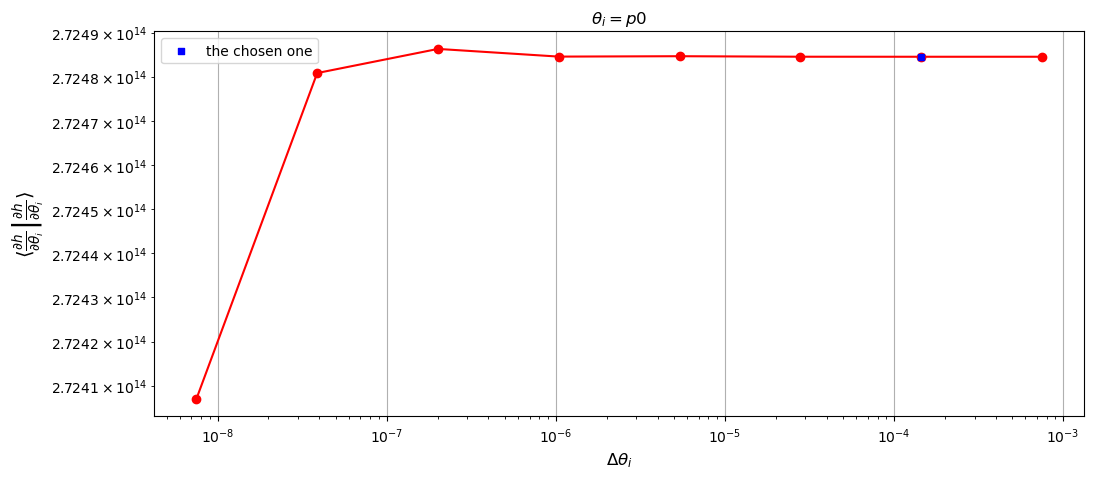

Gamma_ii for e0: 1537358352542270.0
Gamma_ii for e0: 1537358410061083.5
Gamma_ii for e0: 1537358462448763.8
Gamma_ii for e0: 1537358987656269.5
Gamma_ii for e0: 1537335731422989.2
Gamma_ii for e0: 1537463277200439.0
Gamma_ii for e0: 1535942315161918.2
Gamma_ii for e0: 1537576247542584.0
[3.741405590496924e-08, 3.407642493901838e-08, 3.4162971041050597e-07, 1.512762164106051e-05, 8.295858466421235e-05, 0.0009902468494465634, 0.0010626675478872453]
1


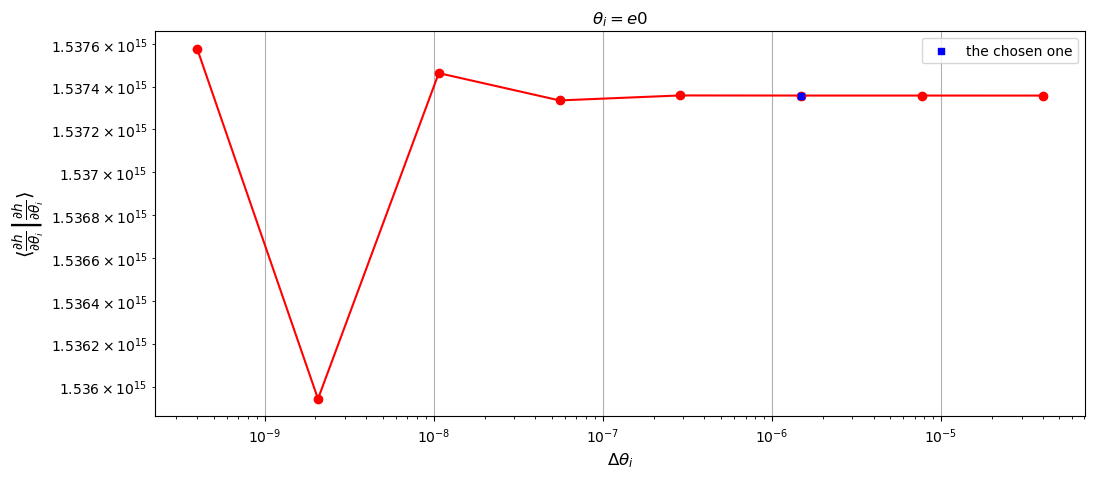

Gamma_ii for qS: 1439903.9059889857
Gamma_ii for qS: 1439904.2910937576
Gamma_ii for qS: 1439904.2916297931
Gamma_ii for qS: 1439904.2916305633
Gamma_ii for qS: 1439904.2916304076
Gamma_ii for qS: 1439904.2916287922
Gamma_ii for qS: 1439904.2916419292
Gamma_ii for qS: 1439904.29172154
[2.6745164544497956e-07, 3.7227162709447435e-10, 5.348992802395315e-13, 1.081764263846086e-13, 1.1218655399958992e-12, 9.123525419805579e-12, 5.5288987691543595e-11]
3


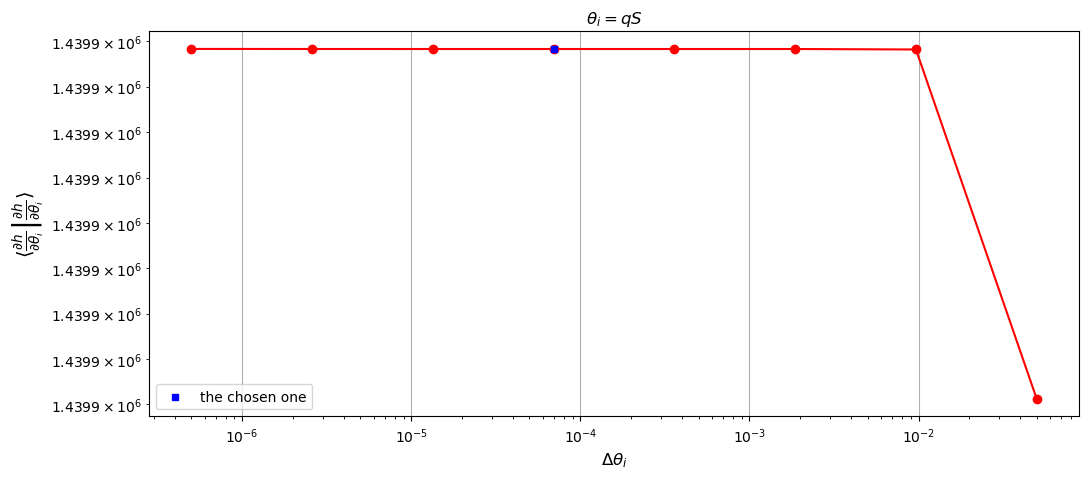

Gamma_ii for phiS: 2268486.896515076
Gamma_ii for phiS: 2268487.3876734637
Gamma_ii for phiS: 2268487.388355454
Gamma_ii for phiS: 2268487.388356414
Gamma_ii for phiS: 2268487.3883564705
Gamma_ii for phiS: 2268487.38835704
Gamma_ii for phiS: 2268487.3883572337
Gamma_ii for phiS: 2268487.388353106
[2.165136073899243e-07, 3.0063658075599673e-10, 4.2327481270426936e-13, 2.4838143713489485e-14, 2.5104999802966954e-13, 8.539394863477809e-14, 1.819547982452044e-12]
3


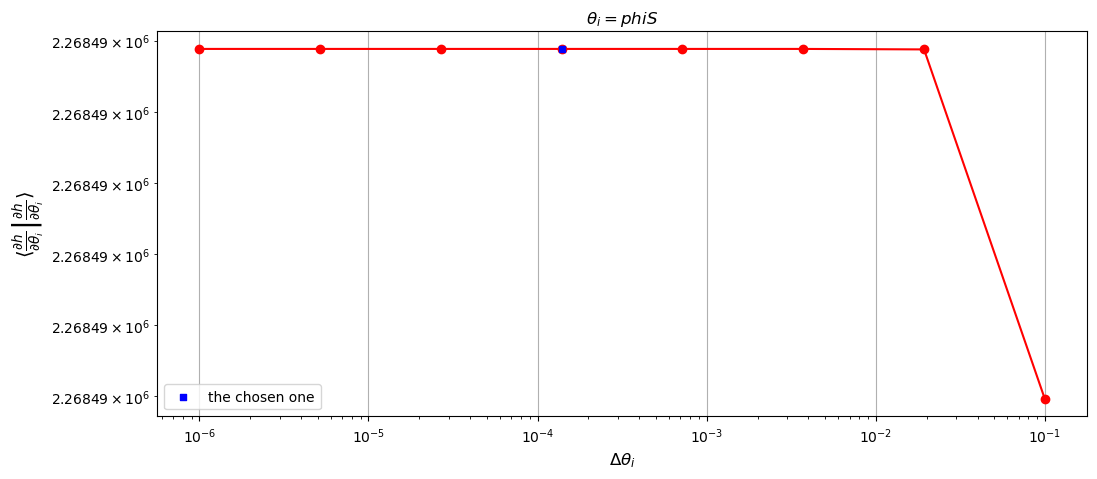

stable deltas: {'m1': 3.72759372031494, 'm2': 0.0005792093186649751, 'a': 1.351488410218275e-05, 'p0': 0.0001448023296662437, 'e0': 1.4910374881259754e-06, 'dist': 0.0, 'qS': 6.947477471865679e-05, 'phiS': 0.00013894954943731373, 'Phi_phi0': 0.0, 'Phi_r0': 0.0}
Time taken to compute stable deltas is 390.7145161628723 seconds
calculating Fisher matrix...
Finished derivatives
Calculated Fisher is *atleast* positive-definite.
Time taken to compute FM is 55.613176345825195 seconds


In [34]:
Fisher = sef(*pars_list, param_names = param_names, 
             T = T, dt = dt, 
             der_order = der_order, 
             Ndelta = Ndelta, 
             stability_plot = stability_plot,
            #  delta_range = delta_range,
            live_dangerously = False)

In [35]:
Fisher

array([[ 5.06135891e+03, -2.94712557e+07,  1.25109193e+09,
         1.16959325e+09,  2.72325267e+09, -1.44496775e-01,
        -6.44305120e+04,  8.25035460e+04, -6.09545506e+04,
        -4.86603390e+03],
       [-2.94712557e+07,  1.84409629e+11, -7.97583249e+12,
        -6.92636151e+12, -1.49035299e+13, -6.06694536e+03,
         3.28176647e+08, -4.20183285e+08,  3.10359373e+08,
         2.39360456e+06],
       [ 1.25109193e+09, -7.97583249e+12,  3.83185675e+14,
         3.01883409e+14,  6.25530107e+14, -1.22783153e+04,
        -1.57792239e+10,  2.02247825e+10, -1.49505634e+10,
         2.68526000e+09],
       [ 1.16959325e+09, -6.92636151e+12,  3.01883409e+14,
         2.72484530e+14,  6.21303308e+14, -1.88292856e+04,
        -1.48829742e+10,  1.90611838e+10, -1.40841599e+10,
        -4.37639316e+08],
       [ 2.72325267e+09, -1.49035299e+13,  6.25530107e+14,
         6.21303308e+14,  1.53735846e+15,  2.52943542e+04,
        -3.85559313e+10,  4.93749527e+10, -3.64857808e+10,
        -4.

In [37]:
np.linalg.eigvals(Fisher)

array([2.07576825e+15, 1.15227878e+14, 2.21677598e+12, 1.80321709e+08,
       6.93923502e+05, 1.14922645e+05, 8.18477077e+04, 5.59067484e-04,
       6.31193126e+03, 3.52516806e+03])

In [38]:
# CHAIN RULE FOR FISHER
J_mx = np.eye(10)
J_mx[0, 0] = m1
J_mx[1, 1] = m2

Fisher_scaled = J_mx.T @ Fisher @ J_mx

(<Figure size 2000x2000 with 55 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [

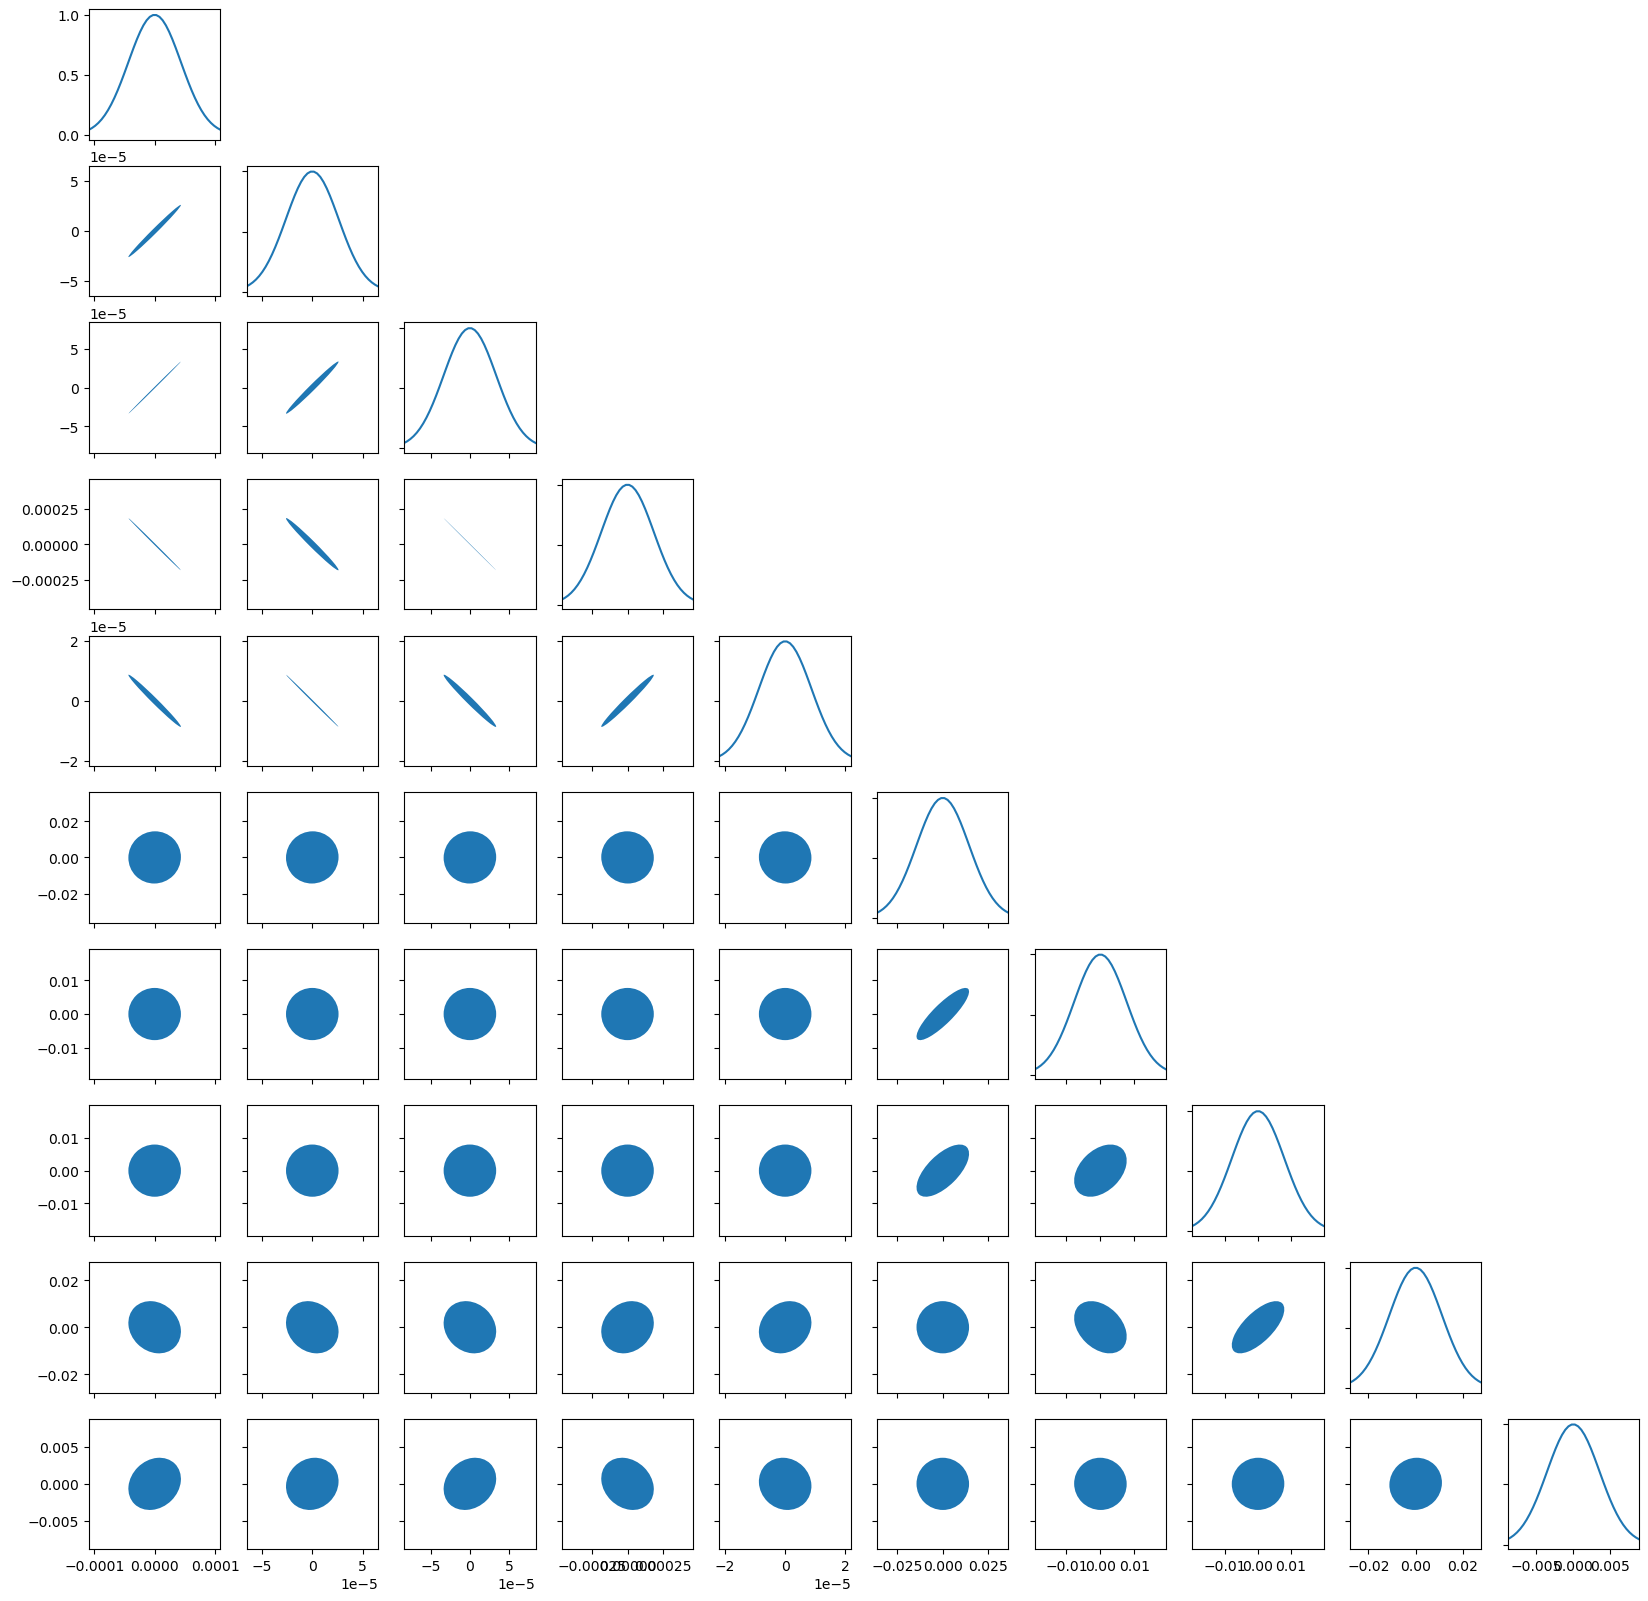

In [39]:
from stableemrifisher.plot import CovEllipsePlot

CovEllipsePlot(np.linalg.inv(Fisher_scaled))

In [40]:
cov = np.linalg.inv(Fisher_scaled)
cov

array([[ 1.89239199e-09,  1.12521365e-09,  1.45968997e-09,
        -8.02912599e-09, -3.75775085e-10,  1.01752634e-08,
        -7.12918859e-11, -5.01713312e-10, -8.00894658e-08,
         2.86841413e-08],
       [ 1.12521365e-09,  6.80292080e-10,  8.64964525e-10,
        -4.75249095e-09, -2.27775655e-10,  6.11886341e-09,
        -4.23174911e-11, -3.09132343e-10, -5.00634493e-08,
         9.29102503e-09],
       [ 1.45968997e-09,  8.64964525e-10,  1.12686673e-09,
        -6.19928654e-09, -2.88621046e-10,  7.82238739e-09,
        -5.38705037e-11, -3.98338358e-10, -6.06241229e-08,
         2.36756736e-08],
       [-8.02912599e-09, -4.75249095e-09, -6.19928654e-09,
         3.41087453e-08,  1.58577788e-09, -4.30129446e-08,
         3.11428935e-10,  2.12990961e-09,  3.33689920e-07,
        -1.35947216e-07],
       [-3.75775085e-10, -2.27775655e-10, -2.88621046e-10,
         1.58577788e-09,  7.63648525e-11, -2.04979669e-09,
         1.53093184e-11,  9.75178565e-11,  1.73451310e-08,
        -2.

In [41]:
np.diag(cov)

array([1.89239199e-09, 6.80292080e-10, 1.12686673e-09, 3.41087453e-08,
       7.63648525e-11, 2.08993440e-04, 5.95259004e-05, 6.36103951e-05,
       1.23648997e-04, 1.25607477e-05])

In [42]:
sigmas = np.sqrt(np.diag(cov))
sigmas

array([4.35016320e-05, 2.60824094e-05, 3.35688358e-05, 1.84685531e-04,
       8.73869856e-06, 1.44566054e-02, 7.71530300e-03, 7.97561252e-03,
       1.11197571e-02, 3.54411451e-03])

In [51]:
for i, name in enumerate(param_names):
    param_value = globals()[name]
    result_low = param_value - sigmas[i]
    result_high = param_value + sigmas[i]
    prior_low = param_value - 3*sigmas[i]
    prior_high = param_value + 3*sigmas[i]
    print(f"=== {name}: {param_value} +/- {sigmas[i]}")
    print(f"1-sigma range: [{result_low:.10e}, {result_high:.10e}]")
    print(f"3-sigma prior range: [{prior_low:.10e}, {prior_high:.10e}]")

=== m1: 1000000.0 +/- 4.350163202886396e-05
1-sigma range: [9.9999999996e+05, 1.0000000000e+06]
3-sigma prior range: [9.9999999987e+05, 1.0000000001e+06]
=== m2: 30.0 +/- 2.6082409400460255e-05
1-sigma range: [2.9999973918e+01, 3.0000026082e+01]
3-sigma prior range: [2.9999921753e+01, 3.0000078247e+01]
=== a: 0.7 +/- 3.356883575392137e-05
1-sigma range: [6.9996643116e-01, 7.0003356884e-01]
3-sigma prior range: [6.9989929349e-01, 7.0010070651e-01]
=== p0: 7.5 +/- 0.00018468553094096946
1-sigma range: [7.4998153145e+00, 7.5001846855e+00]
3-sigma prior range: [7.4994459434e+00, 7.5005540566e+00]
=== e0: 0.4 +/- 8.738698559509227e-06
1-sigma range: [3.9999126130e-01, 4.0000873870e-01]
3-sigma prior range: [3.9997378390e-01, 4.0002621610e-01]
=== dist: 3 +/- 0.014456605396458743
1-sigma range: [2.9855433946e+00, 3.0144566054e+00]
3-sigma prior range: [2.9566301838e+00, 3.0433698162e+00]
=== qS: 0.5 +/- 0.007715302998435591
1-sigma range: [4.9228469700e-01, 5.0771530300e-01]
3-sigma prior ra